# Import

The first step is to import all the libraries needed, and to mount the google drive so that the codes have access to all my receipts training images stored in my Google Drive.

In [ ]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import os
import json
import codecs
from PIL import Image
import pandas as pd
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir source

# Data Preprocessing

Unzip the training images stored separately in three folders.

In [ ]:
! unzip /content/gdrive/MyDrive/Experiments/receipt_img.zip -d source

In [ ]:
! unzip /content/gdrive/MyDrive/Experiments/receipt_img2.zip -d source

In [ ]:
! unzip /content/gdrive/MyDrive/Experiments/receipt_img3.zip -d source

In [ ]:
!unzip /content/gdrive/MyDrive/Experiments/receipt4.zip -d source

In [ ]:
print(os.listdir("/content/gdrive/MyDrive/Experiments/source"))

[]


In [ ]:
for file in os.listdir("/content/source/receipt_img2/"):
  print(file)
  shutil.move("/content/source/receipt_img2/"+file, "/content/source/receipt_img/"+file)
for file in os.listdir("/content/source/receipt_img3/"):
  print(file)
  shutil.move("/content/source/receipt_img3/"+file, "/content/source/receipt_img/"+file)
for file in os.listdir("/content/source/receipt4/"):
  print(file)
  shutil.move("/content/source/receipt4/"+file, "/content/source/receipt_img/"+file)

In [ ]:
files = []
for file in os.listdir(ROOT):
  if file.endswith(".jpg"):
    files.append(file)

In [1]:
WIDTH = 1296
HEIGHT = 1944
RATIO = 4
ROOT = "/content/source/receipt_img/"

In [ ]:
def create_masks(filepath):
  MASKS_PATH = filepath+"/masks/"
  if "masks" not in os.listdir(filepath):
    os.mkdir(MASKS_PATH)
  for file in os.listdir(filepath):
    if file.endswith(".json"):
      mask = np.zeros((int(HEIGHT/RATIO), int(WIDTH/RATIO)))
      filename = file.split("_annotate")[0]
      f = open(filepath + file, "rb")
      json_dict = json.load(f)
      points = json_dict["shapes"][0]["points"]
      points = np.round(np.array(points)/ RATIO, 0)
      points = points.astype(np.int32)
      cv2.fillPoly(mask, [points], 255)
      cv2.imwrite(MASKS_PATH + filename + ".png", mask)

In [ ]:
create_masks("/content/source/receipt_img/")

In [ ]:
np.random.seed(0)
train_index = np.random.choice(len(files), int(len(files)*0.7))
print(train_index)

[172  47 117 192 323 251 195 359   9 211 277 242 292  87  70  88 314 193
  39  87 174  88 337 165  25 333  72 265 115 243 197 335 338  99 177 243
 285 147 147 288 265 185 127  32  31 202 244 151 163 370 183  28 290 128
 128  53  38 244 273 335 105  42  31 376 257 321  57 291 358 119 267  82
  91 384  99  53 121  84 203 324 262  47 127 131 356 180 334 143 148 227
 279 207 373 341  48 305  69 169 163  95 197  94 256 369 178 292 304 349
 387  98  42 368 201 383   0 370  43 383  23 187 130 377  98  62 222 123
  82 227 148 209  50 270  41  58 193  36 266  86  43 360  11 258 307  80
  32 182 128 294 275 174  42 371 184  77 286 280 125 258   3  94 226 363
 269 368 296 328  19  95 328 248 180 323 317 270 352 260 237 139  86 377
 109 331 184  16 152 149 110  25 377 374 117  83 161 360 228 251 121 326
 287  13 327 184 152  79  41 274  40 207 267 166 111 349 129 223 374 300
 216 381  24  67 259 234 204 291 214 189 197 215  43  32  11 104 212 138
 182 125 156 111 258  27 217 151 309 307 174 148  2

In [ ]:
def populate_training_and_testing_dir(train_index, files):
  if "training_images" not in os.listdir(ROOT):
    os.mkdir(ROOT + "training_images/")
  if "val_images" not in os.listdir(ROOT):
    os.mkdir(ROOT + "val_images/")
  if "train_masks" not in os.listdir(ROOT):
    os.mkdir(ROOT + "train_masks/")
  if "val_masks" not in os.listdir(ROOT):
    os.mkdir(ROOT + "val_masks/")
  for i in range(len(files)):
    if i in train_index:
      image = files[i]
      mask = files[i].split(".jpg")[0] + ".png"
      try:
        shutil.copyfile(ROOT+image, ROOT+"training_images/"+image)
        shutil.copyfile(ROOT+"masks/"+mask, ROOT+"train_masks/"+mask)
      except Exception as e:
        print(e)
        print(f"something wrong with either image or mask:{files[i].split('.jpg')[0]}")
    else:
      image = files[i]
      mask =  files[i].split(".jpg")[0] + ".png"
      try:
        shutil.copyfile(ROOT+image, ROOT+"val_images/"+image)
        shutil.copyfile(ROOT+"masks/"+mask, ROOT+"val_masks/"+mask)
      except Exception as e:
        print(e)
        print(f"something wrong with either image or mask:{files[i].split('.jpg')[0]}")

In [ ]:
populate_training_and_testing_dir(train_index, files)

[Errno 2] No such file or directory: '/content/source/receipt_img/masks/20220726T061759.png'
something wrong with either image or mask:20220726T061759
[Errno 2] No such file or directory: '/content/source/receipt_img/masks/20220726T070909.png'
something wrong with either image or mask:20220726T070909


Remove Error Images

In [ ]:
if "20220726T070909.jpg" in os.listdir(ROOT + "training_images/"):
  os.remove(ROOT + "training_images/"+"20220726T070909.jpg")
elif "20220726T070909.jpg" in os.listdir(ROOT + "val_images/"):
  os.remove(ROOT + "val_images/"+"20220726T070909.jpg")

if "20220726T061759.jpg" in os.listdir(ROOT + "training_images/"):
  os.remove(ROOT + "training_images/"+"20220726T061759.jpg")
elif "20220726T061759.jpg" in os.listdir(ROOT + "val_images/"):
  os.remove(ROOT + "val_images/"+"20220726T061759.jpg")

## Loading dataset

In [ ]:
from torch.utils.data import Dataset

class ReceiptDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [ ]:
class ReceiptInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

# Model


In [ ]:
# following the guide in https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/model.py
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Training


In [ ]:
import torchvision
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="/content/gdrive/MyDrive/Experiments/my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = ReceiptDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = ReceiptDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="/content/gdrive/MyDrive/Experiments/saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()


In [ ]:
pip install -U albumentations --no-binary qudida,albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 11
NUM_WORKERS = 2
IMAGE_HEIGHT = int(HEIGHT/RATIO)  # 1280 originally
IMAGE_WIDTH = int(WIDTH/RATIO)  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = "/content/source/receipt_img/training_images/"
TRAIN_MASK_DIR = "/content/source/receipt_img/train_masks/"
VAL_IMG_DIR = "/content/source/receipt_img/val_images/"
VAL_MASK_DIR = "/content/source/receipt_img/val_masks/"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def pipeline():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("/content/gdrive/MyDrive/Experiments/my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="/content/gdrive/MyDrive/Experiments/saved_images/", device=DEVICE
        )

In [ ]:
pipeline()

=> Loading checkpoint
Got 27755653/30075624 with acc 92.29
Dice score: 0.911625862121582


100%|██████████| 13/13 [00:14<00:00,  1.09s/it, loss=0.22]


=> Saving checkpoint
Got 26496007/30075624 with acc 88.10
Dice score: 0.860233724117279


100%|██████████| 13/13 [00:14<00:00,  1.13s/it, loss=0.219]


=> Saving checkpoint
Got 27576437/30075624 with acc 91.69
Dice score: 0.9076882600784302


100%|██████████| 13/13 [00:14<00:00,  1.12s/it, loss=0.157]


=> Saving checkpoint
Got 27787628/30075624 with acc 92.39
Dice score: 0.9133354425430298


100%|██████████| 13/13 [00:14<00:00,  1.13s/it, loss=0.516]


=> Saving checkpoint
Got 25783898/30075624 with acc 85.73
Dice score: 0.8516261577606201


100%|██████████| 13/13 [00:14<00:00,  1.12s/it, loss=0.269]


=> Saving checkpoint
Got 26817014/30075624 with acc 89.17
Dice score: 0.8678018450737


100%|██████████| 13/13 [00:14<00:00,  1.13s/it, loss=0.202]


=> Saving checkpoint
Got 27412055/30075624 with acc 91.14
Dice score: 0.9035307168960571


100%|██████████| 13/13 [00:14<00:00,  1.12s/it, loss=0.131]


=> Saving checkpoint
Got 27890644/30075624 with acc 92.74
Dice score: 0.9155950546264648


100%|██████████| 13/13 [00:14<00:00,  1.11s/it, loss=0.191]


=> Saving checkpoint
Got 27874362/30075624 with acc 92.68
Dice score: 0.9148551821708679


100%|██████████| 13/13 [00:14<00:00,  1.12s/it, loss=0.285]


=> Saving checkpoint
Got 27419405/30075624 with acc 91.17
Dice score: 0.8899083137512207


100%|██████████| 13/13 [00:14<00:00,  1.12s/it, loss=0.185]


=> Saving checkpoint
Got 27686917/30075624 with acc 92.06
Dice score: 0.9112091064453125


100%|██████████| 13/13 [00:14<00:00,  1.14s/it, loss=0.158]


=> Saving checkpoint
Got 27596145/30075624 with acc 91.76
Dice score: 0.9086925387382507


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def test_image(path):
  #image = cv2.imread(path)
  test_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
  )
  image = np.array(Image.open(path).convert("RGB"))
  image = test_transform(image=image)["image"]
  image = image.to(DEVICE).unsqueeze(0)
  model = UNET(in_channels=3, out_channels=1).to(DEVICE)
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
  load_checkpoint(torch.load("/content/gdrive/MyDrive/Experiments/my_checkpoint.pth.tar"), model)
  with torch.no_grad():
      preds = torch.sigmoid(model(image))
      preds = (preds > 0.5).float()
  torchvision.utils.save_image(
      preds, f"/content/gdrive/MyDrive/Experiments/receipts/pred_receipt.png"
  )

In [ ]:
path = "/content/gdrive/MyDrive/Experiments/receipt_img/20220808T070848.jpg"

In [ ]:
test_image(path)

=> Loading checkpoint


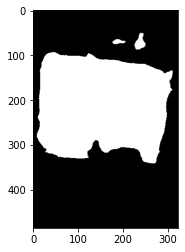

In [ ]:
mask = cv2.imread('/content/gdrive/MyDrive/Experiments/receipts/pred_receipt.png')
mask = mask.copy()
imgplot = plt.imshow(mask)
plt.show()

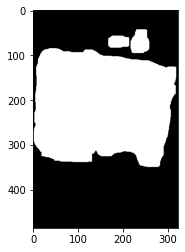

In [ ]:
mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask_gray = mask_gray.astype(np.uint8)
kernel = np.ones((3, 3), np.uint8)
morph = cv2.dilate(mask_gray,  kernel, iterations=8)
imgplot = plt.imshow(morph, cmap='gray')
plt.show()

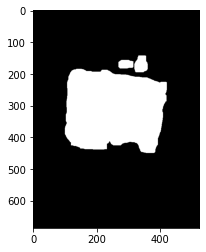

In [ ]:
padded = np.pad(morph, (100, 100), 'constant', constant_values=(0, 0))
imgplot = plt.imshow(padded, cmap='gray')
plt.show()

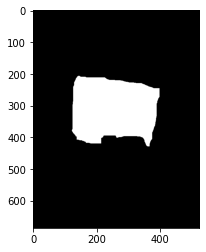

In [ ]:
erode = cv2.erode(padded,  kernel, iterations=18)
imgplot = plt.imshow(erode, cmap='gray')
plt.show()

In [ ]:
contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [ ]:
cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]

In [ ]:
import imutils

[[115.12842 414.94556]
 [128.19067 205.94943]
 [399.13232 222.8833 ]
 [386.07007 431.87943]]


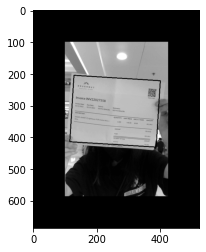

In [ ]:
img = cv2.imread(path)
img = imutils.resize(img, width=int(WIDTH/RATIO))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = np.pad(img, (100, 100), 'constant', constant_values=(0, 0))
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
print(box)
box = np.int0(box)
cv2.drawContours(img,[box],0,(0,255,255),2)
imgplot = plt.imshow(img, cmap="gray")
plt.show()

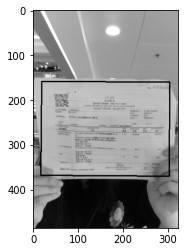

In [ ]:
img = img[100: -100, 100:-100]
imgplot = plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
from scipy.stats import mode

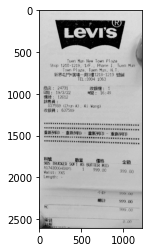

In [ ]:
image = cv2.imread('/content/gdrive/MyDrive/Experiments/receipts/receipt2.jpg')
mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imgplot = plt.imshow(mask, cmap="gray")
plt.show()

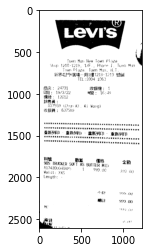

In [ ]:
# gray = cv2.bitwise_not(mask)
_, thresh = cv2.threshold(mask,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
imgplot = plt.imshow(thresh, cmap="gray")
plt.show()

In [ ]:
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
print(angle)
if angle < -45:
  angle = -(90 + angle)
  print("here")
else:
	angle = 90-angle

(h, w) = image.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(image, M, (w, h),
	flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

87.5435562133789


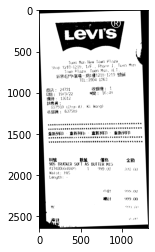

In [ ]:
imgplot = plt.imshow(rotated, cmap='gray')
plt.imsave("/content/gdrive/MyDrive/Experiments/receipts/fixedSkew.jpg", rotated)
plt.show()

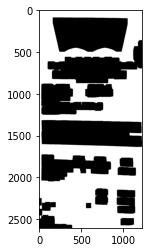

In [ ]:
kernel = np.ones((3, 3), np.uint8)
erode = cv2.erode(thresh,  kernel, iterations=30)
imgplot = plt.imshow(erode, cmap='gray')
plt.show()

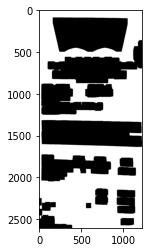

In [ ]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(src=erode, ddepth=-1, kernel=kernel)
imgplot = plt.imshow(image_sharp, cmap='gray')
plt.show()

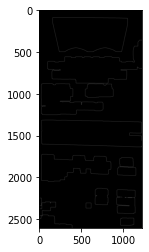

In [ ]:
edged = cv2.Canny(image_sharp,0, 255)
imgplot = plt.imshow(edged, cmap='gray')
plt.show()

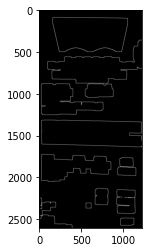

In [ ]:
kernel = np.ones((3,3),np.uint8)
output = cv2.morphologyEx(edged, cv2.MORPH_GRADIENT, kernel)
imgplot = plt.imshow(output, cmap='gray')
plt.show()

In [ ]:
lines = cv2.HoughLines(output, 1, np.pi/180, 700, None, 0, 0)
print(len(lines))

2


In [ ]:
lu = []
img = np.zeros(erode.shape[:2])
for r_theta in lines:
    arr = np.array(r_theta[0], dtype=np.float64)
    r, theta = arr
    print(theta)
    # Stores the value of cos(theta) in a
    a = np.cos(theta)

    # Stores the value of sin(theta) in b
    b = np.sin(theta)

    # x0 stores the value rcos(theta)
    x0 = a*r
    y0 = b*r
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img, (x1, y1), (x2, y2), 255, 2)

1.5882495641708374
1.6057028770446777


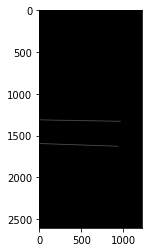

In [ ]:
imgplot = plt.imshow(img, cmap='gray')
plt.show()

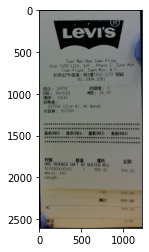

In [ ]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, int(angle), 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

thetas = [l[0][1] for l in lines]
freq = mode(np.around(thetas, decimals=2))[0]
rotated = rotate_image(image, float((freq - np.pi/2)*180/np.pi))
imgplot = plt.imshow(rotated, cmap="gray")
plt.imsave("/content/gdrive/MyDrive/Experiments/receipts/fixedSkew2.jpg", rotated, cmap="gray")
plt.show()

In [ ]:
pip install deskew

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from skimage.transform import rotate
from deskew import determine_skew
from scipy.ndimage import interpolation as inter

In [ ]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    #thresh = image
    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    print(angles)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    print(center)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)
    return best_angle, corrected

[-5 -4 -3 -2 -1  0  1  2  3  4  5]
(615, 1302)
1


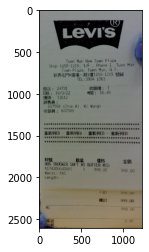

In [ ]:
#print(thresh)
angle, corrected = correct_skew(image)
print(angle)
plt.imsave("/content/gdrive/MyDrive/Experiments/receipts/fixedSkew.jpg", corrected)
plt.imshow(corrected, cmap="gray")
plt.show()